# Introduction to Ensembling

*Adapted from Chapter 8 of [An Introduction to Statistical Learning](http://www-bcf.usc.edu/~gareth/ISL/)*

Let's pretend that instead of building a single model to solve a classification problem, you created **five independent models**, and each model was correct 70% of the time. If you combined these models into an "ensemble" and used their majority vote as a prediction, how often would the ensemble be correct?

Let's simulate it to find out!

In [46]:
import numpy as np

# set a seed for reproducibility
np.random.seed(1234)

# generate 1000 random numbers (between 0 and 1) for each model, representing 1000 observations
mod1 = np.random.rand(1000)
mod2 = np.random.rand(1000)
mod3 = np.random.rand(1000)
mod4 = np.random.rand(1000)
mod5 = np.random.rand(1000)

# each model independently predicts 1 (the "correct response") if random number was at least 0.3
preds1 = np.where(mod1 > 0.3, 1, 0) # When greater than 0.3, can create predicition
preds2 = np.where(mod2 > 0.3, 1, 0)
preds3 = np.where(mod3 > 0.3, 1, 0)
preds4 = np.where(mod4 > 0.3, 1, 0)
preds5 = np.where(mod5 > 0.3, 1, 0)

# print the first 20 predictions from each model
print preds1[:20]
print preds2[:20]
print preds3[:20]
print preds4[:20]
print preds5[:20]

[0 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1]
[1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0]
[1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 1 1 0 1 1]
[1 1 0 0 0 0 1 1 0 1 1 1 1 1 1 0 1 1 1 0]
[0 0 1 0 0 0 1 0 1 0 0 0 1 1 1 1 1 1 1 1]


In [47]:
# add the predictions together
sum_of_preds = preds1 + preds2 + preds3 + preds4 + preds5

# ensemble predicts 1 (the "correct response") if at least 3 models predict 1
ensemble_preds = np.where(sum_of_preds >=3 , 1, 0)

# print the ensemble's first 20 predictions
print ensemble_preds[:20]

[1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 1 1]


In [48]:
# how accurate was the ensemble?
preds4.mean() # average of 'correct' responses for 1 model

#ensemble_preds.mean() # average of 'correct' responses for ensemble 
# 0.84099999999999997

0.71199999999999997

Amazing, right?

**Ensemble learning (or "ensembling")** is simply the process of combining several models to solve a prediction problem, with the goal of producing a combined model that is more accurate than any individual model. For **classification** problems, the combination is often done by majority vote. For **regression** problems, the combination is often done by taking an average of the predictions.

For ensembling to work well, the individual models must meet two conditions:

- Models should be **accurate** (they must outperform random guessing)
- Models should be **independent** (their predictions are not correlated with one another)

The idea, then, is that if you have a collection of individually imperfect (and independent) models, the "one-off" mistakes made by each model are probably not going to be made by the rest of the models, and thus the mistakes will be discarded when averaging the models.

It turns out that as you add more models to the voting process, the probability of error decreases. This is known as [Condorcet's Jury Theorem](http://en.wikipedia.org/wiki/Condorcet%27s_jury_theorem), which was developed by a French political scientist in the 18th century.

Anyway, we'll see examples of ensembling below.

## Bootstrapping

**Some preliminary terminology:** In statistics, "bootstrapping" refers to the process of using "bootstrap samples" to quantify the uncertainty of a model. Bootstrap samples are simply random samples with replacement:

In [49]:
# set a seed for reproducibility
np.random.seed(1)

# create an array of 0 to 9, then sample 10 times with replacement
np.random.choice(a=10, size=10, replace=True)

array([5, 8, 9, 5, 0, 0, 1, 7, 6, 9])

## Bagging

On their own, decision trees are not competitive with the best supervised learning methods in terms of **predictive accuracy**. However, they can be used as the basis for more sophisticated methods that have much higher accuracy!

One of the main issues with decision trees is **high variance**, meaning that different splits in the training data can lead to very different trees. **"Bootstrap aggregation" (aka "bagging")** is a general purpose procedure for reducing the variance of a machine learning method, but is particularly useful for decision trees.

What is the bagging process (in general)?

- Take repeated bootstrap samples (random samples with replacement) from the training data set
- Train our method on each bootstrapped training set and make predictions
- Average the predictions

This increases predictive accuracy by **reducing the variance**, similar to how cross-validation reduces the variance associated with the test set approach (for estimating out-of-sample error) by splitting many times an averaging the results.

## Applying bagging to decision trees

So how exactly can bagging be used with decision trees? Here's how it applies to **regression trees**:

- Grow B regression trees using B bootstrapped training sets
- Grow each tree deep so that each one has low bias
- Every tree makes a numeric prediction, and the predictions are averaged (to reduce the variance)

It is applied in a similar fashion to **classification trees**, except that during the prediction stage, the overall prediction is based upon a majority vote of the trees.

**What value should be used for B?** Simply use a large enough value that the error seems to have stabilized. (Choosing a value of B that is "too large" will generally not lead to overfitting.)

## Manually implementing bagged decision trees (with B=3)

In [50]:
import pandas as pd

# read in vehicle data
vehicles = pd.read_csv('used_vehicles.csv')

# convert car to 0 and truck to 1
vehicles['type'] = vehicles.type.map({'car':0, 'truck':1})

# print out data
vehicles

,price,year,miles,doors,type
0,22000,2012,13000,2,0
1,14000,2010,30000,2,0
2,13000,2010,73500,4,0
3,9500,2009,78000,4,0
4,9000,2007,47000,4,0
5,4000,2006,124000,2,0
6,3000,2004,177000,4,0
7,2000,2004,209000,4,1
8,3000,2003,138000,2,0
9,1900,2003,160000,4,0


In [51]:
# calculate the number of rows in vehicles
n_rows = vehicles.shape[0]

# set a seed for reproducibility
np.random.seed(123)

# create three bootstrap samples (will be used to select rows from the DataFrame)
sample1 = np.random.choice(a=n_rows, size=n_rows, replace=True)
sample2 = np.random.choice(a=n_rows, size=n_rows, replace=True)
sample3 = np.random.choice(a=n_rows, size=n_rows, replace=True)

# print samples
print sample1
print sample2
print sample3

[13  2 12  2  6  1  3 10 11  9  6  1  0  1]
[ 9  0  0  9  3 13  4  0  0  4  1  7  3  2]
[ 4  7  2  4  8 13  0  7  9  3 12 12  4  6]


In [52]:
# use sample1 to select rows from DataFrame
print vehicles.iloc[sample1, :]

    price  year   miles  doors  type
13   1300  1997  138000      4     0
2   13000  2010   73500      4     0
12   1800  1999  163000      2     1
2   13000  2010   73500      4     0
6    3000  2004  177000      4     0
1   14000  2010   30000      2     0
3    9500  2009   78000      4     0
10   2500  2003  190000      2     1
11   5000  2001   62000      4     0
9    1900  2003  160000      4     0
6    3000  2004  177000      4     0
1   14000  2010   30000      2     0
0   22000  2012   13000      2     0
1   14000  2010   30000      2     0


In [53]:
from sklearn.tree import DecisionTreeRegressor

# grow one regression tree with each bootstrapped training set
treereg1 = DecisionTreeRegressor(random_state=123)
treereg1.fit(vehicles.iloc[sample1, 1:], vehicles.iloc[sample1, 0])

treereg2 = DecisionTreeRegressor(random_state=123)
treereg2.fit(vehicles.iloc[sample2, 1:], vehicles.iloc[sample2, 0])

treereg3 = DecisionTreeRegressor(random_state=123)
treereg3.fit(vehicles.iloc[sample3, 1:], vehicles.iloc[sample3, 0]) # 
#vehicles.iloc[sample3, 1:] # year, miles, doors, type
#vehicles.iloc[sample3, 0] # price

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=123,
           splitter='best')

In [54]:
# read in out-of-sample data
oos = pd.read_csv('used_vehicles_oos.csv')

# convert car to 0 and truck to 1
oos['type'] = oos.type.map({'car':0, 'truck':1})

# print data
oos

,price,year,miles,doors,type
0,3000,2003,130000,4,1
1,6000,2005,82500,4,0
2,12000,2010,60000,2,0


In [55]:
# select feature columns (every column except for the 0th column)
feature_cols = vehicles.columns[1:]

# make predictions on out-of-sample data
preds1 = treereg1.predict(oos[feature_cols])
preds2 = treereg2.predict(oos[feature_cols])
preds3 = treereg3.predict(oos[feature_cols])

# print predictions
print preds1
print preds2
print preds3

[  1300.   5000.  14000.]
[  1300.   1300.  13000.]
[  3000.   3000.  13000.]


In [56]:
# average predictions and compare to actual values
print (preds1 + preds2 + preds3)/3
print oos.price.values

[  1866.66666667   3100.          13333.33333333]
[ 3000  6000 12000]


## Estimating out-of-sample error

Bagged models have a very nice property: **out-of-sample error can be estimated without using the test set approach or cross-validation!**

Here's how the out-of-sample estimation process works with bagged trees:

- On average, each bagged tree uses about two-thirds of the observations. **For each tree, the remaining observations are called "out-of-bag" observations.**
- For the first observation in the training data, predict its response using **only** the trees in which that observation was out-of-bag. Average those predictions (for regression) or take a majority vote (for classification).
- Repeat this process for every observation in the training data.
- Compare all predictions to the actual responses in order to compute a mean squared error or classification error. This is known as the **out-of-bag error**.

**When B is sufficiently large, the out-of-bag error is an accurate estimate of out-of-sample error.**

In [57]:
# set is a data structure used to identify unique elements
print set(range(14))

# only show the unique elements in sample1
print set(sample1)

set([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13])
set([0, 1, 2, 3, 6, 9, 10, 11, 12, 13])


In [58]:
# use the "set difference" to identify the out-of-bag observations for each tree
print sorted(set(range(14)) - set(sample1))
print sorted(set(range(14)) - set(sample2))
print sorted(set(range(14)) - set(sample3))

[4, 5, 7, 8]
[5, 6, 8, 10, 11, 12]
[1, 5, 10, 11]


Thus, we would predict the response for **observation 4** by using tree 1 (because it is only out-of-bag for tree 1). We would predict the response for **observation 5** by averaging the predictions from trees 1, 2, and 3 (since it is out-of-bag for all three trees). We would repeat this process for all observations, and then calculate the MSE using those predictions.

## Estimating variable importance

Although bagging **increases predictive accuracy**, it **decreases model interpretability** because it's no longer possible to visualize the tree to understand the importance of each variable.

However, we can still obtain an overall summary of "variable importance" from bagged models:

- To compute variable importance for bagged regression trees, we can calculate the **total amount that the mean squared error is decreased due to splits over a given predictor, averaged over all trees**.
- A similar process is used for bagged classification trees, except we use the Gini index instead of the mean squared error.

(We'll see an example of this below.)

## Random Forests

Random Forests is a **slight variation of bagged trees** that has even better performance! Here's how it works:

- Exactly like bagging, we create an ensemble of decision trees using bootstrapped samples of the training set.
- However, when building each tree, **each time a split is considered**, a random sample of m predictors is chosen as split candidates from the full set of p predictors. **The split is only allowed to use one of those m predictors.**

Notes:

- A new random sample of predictors is chosen for **every single tree at every single split**.
- For **classification**, m is typically chosen to be the square root of p. For **regression**, m is typically chosen to be somewhere between p/3 and p.

What's the point?

- Suppose there is one very strong predictor in the data set. When using bagged trees, most of the trees will use that predictor as the top split, resulting in an ensemble of similar trees that are "highly correlated".
- Averaging highly correlated quantities does not significantly reduce variance (which is the entire goal of bagging).
- **By randomly leaving out candidate predictors from each split, Random Forests "decorrelates" the trees**, such that the averaging process can reduce the variance of the resulting model.

In [59]:
# read in the Titanic data
titanic = pd.read_csv('titanic.csv')

# encode sex feature
titanic['Sex'] = titanic.Sex.map({'female':0, 'male':1})

# fill in missing values for age
titanic.Age.fillna(titanic.Age.mean(), inplace=True)

# create three dummy variables, drop the first dummy variable, and store this as a DataFrame
embarked_dummies = pd.get_dummies(titanic.Embarked, prefix='Embarked').iloc[:, 1:]

# concatenate the two dummy variable columns onto the original DataFrame
# note: axis=0 means rows, axis=1 means columns
titanic = pd.concat([titanic, embarked_dummies], axis=1)

# create a list of feature columns
feature_cols = ['Pclass', 'Sex', 'Age', 'Embarked_Q', 'Embarked_S']

# print the updated DataFrame
titanic.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,NaN,S,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,C85,C,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,NaN,S,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,C123,S,0.0,1.0
4,5,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,NaN,S,0.0,1.0
5,6,0,3,"Moran, Mr. James",1,29.699118,0,0,330877,8.4583,NaN,Q,1.0,0.0
6,7,0,1,"McCarthy, Mr. Timothy J",1,54.000000,0,0,17463,51.8625,E46,S,0.0,1.0
7,8,0,3,"Palsson, Master. Gosta Leonard",1,2.000000,3,1,349909,21.0750,NaN,S,0.0,1.0
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",0,27.000000,0,2,347742,11.1333,NaN,S,0.0,1.0
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",0,14.000000,1,0,237736,30.0708,NaN,C,0.0,0.0


In [62]:
# import class, instantiate estimator, fit with all data
from sklearn.ensemble import RandomForestClassifier
rfclf = RandomForestClassifier(n_estimators=100, max_features='auto', oob_score=True, random_state=1)
rfclf.fit(titanic[feature_cols], titanic.Survived)

#titanic[feature_cols] # Pclass, Sex, Age, Embarked_Q, Embarked_S
#titanic.Survived # Target

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=1, verbose=0, warm_start=False)

These are the most important tuning parameters for Random Forests:

- **n_estimators:** more estimators (trees) increases performance but decreases speed
- **max_features:** cross-validate to choose an ideal value

In [19]:
# compute the feature importances
pd.DataFrame({'feature':feature_cols, 'importance':rfclf.feature_importances_})

,feature,importance
0,Pclass,0.160553
1,Sex,0.366700
2,Age,0.434528
3,Embarked_Q,0.012129
4,Embarked_S,0.026089


In [20]:
# compute the out-of-bag classification accuracy
rfclf.oob_score_

0.80022446689113358

## More Random Forest

Read the following recent post on the Yhat blog which talks about Random forest. Try running the code here as well
http://blog.yhat.com/posts/python-random-forest.html

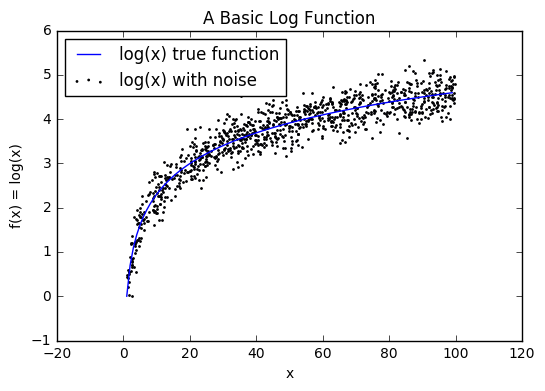

In [24]:
# http://blog.yhat.com/posts/python-random-forest.html

import numpy as np
import pylab as pl

x = np.random.uniform(1, 100, 1000)
y = np.log(x) + np.random.normal(0, .3, 1000)

pl.scatter(x, y, s=1, label="log(x) with noise")
pl.plot(np.arange(1, 100), np.log(np.arange(1, 100)), c="b", label="log(x) true function")
pl.xlabel("x")
pl.ylabel("f(x) = log(x)")
pl.legend(loc="best")
pl.title("A Basic Log Function")
pl.show() 

In [25]:
# http://blog.yhat.com/posts/python-random-forest.html

from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.head()

train, test = df[df['is_train']==True], df[df['is_train']==False]

features = df.columns[:4]
clf = RandomForestClassifier(n_jobs=2)
y, _ = pd.factorize(train['species'])
clf.fit(train[features], y)

preds = iris.target_names[clf.predict(test[features])]
pd.crosstab(test['species'], preds, rownames=['actual'], colnames=['preds'])

preds,setosa,versicolor,virginica
actual,,,
setosa,8,0,0
versicolor,0,8,0
virginica,0,3,12


## Boosting

To go over Extreme Gradient Boosting (XGBOOST) have a look at the following kaggle script

[Understanding XGBOOST on the Oto Dataset](https://www.kaggle.com/tqchen/otto-group-product-classification-challenge/understanding-xgboost-model-on-otto-data/notebook)

Or try installing yourself [from github ](https://github.com/dmlc/xgboost/blob/master/doc/build.md)




## Wrapping up ensembling

Ensembling is incredibly popular, when the **primary goal is predictive accuracy**. For example, the team that eventually won the $1 million [Netflix Prize](http://en.wikipedia.org/wiki/Netflix_Prize) used an [ensemble of 107 models](http://www2.research.att.com/~volinsky/papers/chance.pdf) early on in the competition.

There was a recent paper in the Journal of Machine Learning Research titled "[Do We Need Hundreds of Classifiers to Solve Real World Classification Problems?](http://jmlr.csail.mit.edu/papers/volume15/delgado14a/delgado14a.pdf)" (**Spoiler alert:** Random Forests did very well.) In the [comments about the paper](https://news.ycombinator.com/item?id=8719723) on Hacker News, Ben Hamner (Kaggle's chief scientist) said the following:

> This is consistent with our experience running hundreds of Kaggle competitions: for most classification problems, some variation on ensembled decision trees (random forests, gradient boosted machines, etc.) performs the best. This is typically in conjunction with clever data processing, feature selection, and internal validation.

> One key exception is where the data is richly and hierarchically structured. Text, speech, and visual data falls under this category. In many cases here, variations of neural networks (deep neural nets/CNN's/RNN's/etc.) provide very dramatic improvements.

But as you can imagine, ensembling may not often be practical in a real-time environment.

**You can also build your own ensembles:** just build a variety of models and average them together! Here are some strategies for building independent models:

- using different models
- choosing different combinations of features
- changing the tuning parameters

## Resources

- scikit-learn documentation: [Ensemble Methods](http://scikit-learn.org/stable/modules/ensemble.html)
- Quora: [How do random forests work in layman's terms?](http://www.quora.com/How-do-random-forests-work-in-laymans-terms/answer/Edwin-Chen-1)